In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import requests
import warnings
import re
from scipy import stats
from glob import glob

In [2]:
%matplotlib inline
pd.set_option("display.max_columns", None)
warnings.filterwarnings(action='once')

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

C:\Users\jltsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.TextIOWrapper name='style-table.css' mode='r' encoding='cp1252'>
  
C:\Users\jltsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.TextIOWrapper name='style-notebook.css' mode='r' encoding='cp1252'>
  


The data being being explored comes from 146704 5v5 ranked games in the 2018 season.  Match data was gathered from players that ranked Diamond or above.  Most matches come Challenger level tier, the top tier in League.

Load in all Data as one Pandas Dataframe

In [4]:
files = glob('PlayerMatches\\match_data_*.csv')

In [5]:
dataframes = [pd.read_csv(f) for f in files];

C:\Users\jltsa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (30,31,139,140,248,249,357,358,466,467,575,576,684,685,793,794,902,903,1011,1012) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\jltsa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (30,31,34,35,139,140,143,144,248,249,252,253,357,358,361,362,466,467,470,471,575,576,579,580,684,685,688,689,793,794,797,798,902,903,906,907,1011,1012,1015,1016) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
concat = pd.concat(dataframes, ignore_index=True)

Further cleaning of the data as we do exploratory data analysis.

I found out there are columns that existed to hold data from older game modes that are no longer in the game, but the columns still exist with 0 values.  These columns will be removed

In [7]:
#Removing columns that have all 0 values 'p#playerScore#'
def remove_cols():
    l = []
    for num in range(10):
        for num2 in range(10):
            col = f'p{num+1}playerScore{num2}'
            l.append(col)
    
    return l
    

In [8]:
r = remove_cols()
2 #other columns with no data
col = ['blue_team_dominionVictoryScore', 'red_team_dominionVictoryScore',
        'Unnamed: 0', 'blue_team_vilemawKills', 'red_team_vilemawKills']
r += col

In [9]:
#remove columns not needed
concat.drop(axis=1, labels=r, inplace=True)

In [10]:
#verbose=True to see all info
concat.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146704 entries, 0 to 146703
Columns: 1016 entries, blue_team_baronKills to red_team_win
dtypes: bool(22), float64(34), int64(782), object(178)
memory usage: 1.1+ GB


As you can see there still some columns that contain null values.  The columns are kept because null values in 'perk' columns means the player did not choose the perk.  For items, null values represent a slot in inventory that was not used.

In [11]:
concat.head()

,blue_team_baronKills,blue_team_dragonKills,blue_team_firstBaron,blue_team_firstBlood,blue_team_firstDragon,blue_team_firstInhibitor,blue_team_firstRiftHerald,blue_team_firstTower,blue_team_inhibitorKills,blue_team_riftHeraldKills,blue_team_towerKills,blue_team_win,game_id,game_length_mins,p10_champ,p10_name,p10_spell1,p10_spell2,p10_team,p10assists,p10champLevel,p10combatPlayerScore,p10damageDealtToObjectives,p10damageDealtToTurrets,p10damageSelfMitigated,p10deaths,p10doubleKills,p10firstBloodAssist,p10firstBloodKill,p10firstInhibitorAssist,p10firstInhibitorKill,p10firstTowerAssist,p10firstTowerKill,p10goldEarned,p10goldSpent,p10inhibitorKills,p10item0,p10item1,p10item2,p10item3,p10item4,p10item5,p10item6,p10killingSprees,p10kills,p10largestCriticalStrike,p10largestKillingSpree,p10largestMultiKill,p10longestTimeSpentLiving,p10magicDamageDealt,p10magicDamageDealtToChampions,p10magicalDamageTaken,p10neutralMinionsKilled,p10neutralMinionsKilledEnemyJungle,p10neutralMinionsKilledTeamJungle,p10objectivePlayerScore,p10participantId,p10pentaKills,p10perk0,p10perk0Var1,p10perk0Var2,p10perk0Var3,p10perk1,p10perk1Var1,p10perk1Var2,p10perk1Var3,p10perk2,p10perk2Var1,p10perk2Var2,p10perk2Var3,p10perk3,p10perk3Var1,p10perk3Var2,p10perk3Var3,p10perk4,p10perk4Var1,p10perk4Var2,p10perk4Var3,p10perk5,p10perk5Var1,p10perk5Var2,p10perk5Var3,p10perkPrimaryStyle,p10perkSubStyle,p10physicalDamageDealt,p10physicalDamageDealtToChampions,p10physicalDamageTaken,p10quadraKills,p10sightWardsBoughtInGame,p10statPerk0,p10statPerk1,p10statPerk2,p10timeCCingOthers,p10totalDamageDealt,p10totalDamageDealtToChampions,p10totalDamageTaken,p10totalHeal,p10totalMinionsKilled,p10totalPlayerScore,p10totalScoreRank,p10totalTimeCrowdControlDealt,p10totalUnitsHealed,p10tripleKills,p10trueDamageDealt,p10trueDamageDealtToChampions,p10trueDamageTaken,p10turretKills,p10unrealKills,p10visionScore,p10visionWardsBoughtInGame,p10wardsKilled,p10wardsPlaced,p10win,p1_champ,p1_name,p1_spell1,p1_spell2,p1_team,p1assists,p1champLevel,p1combatPlayerScore,p1damageDealtToObjectives,p1damageDealtToTurrets,p1damageSelfMitigated,p1deaths,p1doubleKills,p1firstBloodAssist,p1firstBloodKill,p1firstInhibitorAssist,p1firstInhibitorKill,p1firstTowerAssist,p1firstTowerKill,p1goldEarned,p1goldSpent,p1inhibitorKills,p1item0,p1item1,p1item2,p1item3,p1item4,p1item5,p1item6,p1killingSprees,p1kills,p1largestCriticalStrike,p1largestKillingSpree,p1largestMultiKill,p1longestTimeSpentLiving,p1magicDamageDealt,p1magicDamageDealtToChampions,p1magicalDamageTaken,p1neutralMinionsKilled,p1neutralMinionsKilledEnemyJungle,p1neutralMinionsKilledTeamJungle,p1objectivePlayerScore,p1participantId,p1pentaKills,p1perk0,p1perk0Var1,p1perk0Var2,p1perk0Var3,p1perk1,p1perk1Var1,p1perk1Var2,p1perk1Var3,p1perk2,p1perk2Var1,p1perk2Var2,p1perk2Var3,p1perk3,p1perk3Var1,p1perk3Var2,p1perk3Var3,p1perk4,p1perk4Var1,p1perk4Var2,p1perk4Var3,p1perk5,p1perk5Var1,p1perk5Var2,p1perk5Var3,p1perkPrimaryStyle,p1perkSubStyle,p1physicalDamageDealt,p1physicalDamageDealtToChampions,p1physicalDamageTaken,p1quadraKills,p1sightWardsBoughtInGame,p1statPerk0,p1statPerk1,p1statPerk2,p1timeCCingOthers,p1totalDamageDealt,p1totalDamageDealtToChampions,p1totalDamageTaken,p1totalHeal,p1totalMinionsKilled,p1totalPlayerScore,p1totalScoreRank,p1totalTimeCrowdControlDealt,p1totalUnitsHealed,p1tripleKills,p1trueDamageDealt,p1trueDamageDealtToChampions,p1trueDamageTaken,p1turretKills,p1unrealKills,p1visionScore,p1visionWardsBoughtInGame,p1wardsKilled,p1wardsPlaced,p1win,p2_champ,p2_name,p2_spell1,p2_spell2,p2_team,p2assists,p2champLevel,p2combatPlayerScore,p2damageDealtToObjectives,p2damageDealtToTurrets,p2damageSelfMitigated,p2deaths,p2doubleKills,p2firstBloodAssist,p2firstBloodKill,p2firstInhibitorAssist,p2firstInhibitorKill,p2firstTowerAssist,p2firstTowerKill,p2goldEarned,p2goldSpent,p2inhibitorKills,p2item0,p2item1,p2item2,p2item3,p2item4,p2item5,p2item6,p2killingSprees,p2kills,p2largestCriticalStrike,p2largestKillingSpree,p2largestMultiKill,p2longestTime

Questions:
What factors have an effect on game times?

Did 2018 World championship have any affect on the game?

What factors affect win and loose rates? Items? Champs?


Creating a function that will return all games with a specific champion played.  Plans to use this later in exploring data.

Exploring factors that affect matchtimes

Champ types?  Does having a certain type of champ in a game affect game time?

In [12]:
#Champion Information
champion_data_url = 'http://ddragon.leagueoflegends.com/cdn/8.24.1/data/en_US/champion.json'
champ_response = requests.get(champion_data_url)
champ_json = champ_response.json()
#champ_json

In [13]:
#Champ list
champ_list = []
for champ in champ_json['data']:
    champ_list.append(champ)
#champ_list

In [14]:
#Champ type
champ_type = {}

for champ in champ_list:
    champ_type[champ] = champ_json['data'][champ]['tags']

#champ_type

In [15]:
#Find the primary role
prim_roles = {}
for champ in champ_type:
    prim_roles[champ] = champ_type[champ][0]

In [16]:
#Find secondary champ role if there is one
sec_roles = {}
for champ in champ_type:
    if len(champ_type[champ]) != 2:
        sec_roles[champ] = "None"
    else:
        sec_roles[champ] = champ_type[champ][1]

In [129]:
#create dataframe of champs
champ_roles_df = concat[['p1_champ', 'p2_champ', 'p3_champ', 'p4_champ', 'p5_champ',
                        'p6_champ', 'p7_champ', 'p8_champ', 'p9_champ', 'p10_champ',
                        'game_length_mins', 'game_id']]


In [128]:
#create dataframe of champ types/roles
#map champion roles
def add_roles(champ_roles_df):
    champ_roles_df['p1_champ_prim_role'] = champ_roles_df['p1_champ'].map(prim_roles)
    champ_roles_df['p2_champ_prim_role'] = champ_roles_df['p2_champ'].map(prim_roles)
    champ_roles_df['p3_champ_prim_role'] = champ_roles_df['p3_champ'].map(prim_roles)
    champ_roles_df['p4_champ_prim_role'] = champ_roles_df['p4_champ'].map(prim_roles)
    champ_roles_df['p5_champ_prim_role'] = champ_roles_df['p5_champ'].map(prim_roles)
    champ_roles_df['p6_champ_prim_role'] = champ_roles_df['p6_champ'].map(prim_roles)
    champ_roles_df['p7_champ_prim_role'] = champ_roles_df['p7_champ'].map(prim_roles)
    champ_roles_df['p8_champ_prim_role'] = champ_roles_df['p8_champ'].map(prim_roles)
    champ_roles_df['p9_champ_prim_role'] = champ_roles_df['p9_champ'].map(prim_roles)
    champ_roles_df['p10_champ_prim_role'] = champ_roles_df['p10_champ'].map(prim_roles)
    champ_roles_df['p1_champ_sec_role'] = champ_roles_df['p1_champ'].map(sec_roles)
    champ_roles_df['p2_champ_sec_role'] = champ_roles_df['p2_champ'].map(sec_roles)
    champ_roles_df['p3_champ_sec_role'] = champ_roles_df['p3_champ'].map(sec_roles)
    champ_roles_df['p4_champ_sec_role'] = champ_roles_df['p4_champ'].map(sec_roles)
    champ_roles_df['p5_champ_sec_role'] = champ_roles_df['p5_champ'].map(sec_roles)
    champ_roles_df['p6_champ_sec_role'] = champ_roles_df['p6_champ'].map(sec_roles)
    champ_roles_df['p7_champ_sec_role'] = champ_roles_df['p7_champ'].map(sec_roles)
    champ_roles_df['p8_champ_sec_role'] = champ_roles_df['p8_champ'].map(sec_roles)
    champ_roles_df['p9_champ_sec_role'] = champ_roles_df['p9_champ'].map(sec_roles)
    champ_roles_df['p10_champ_sec_role'] = champ_roles_df['p10_champ'].map(sec_roles)

In [131]:
add_roles(champ_roles_df)

C:\Users\jltsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [133]:
#convert seconds to minutes
champ_roles_df.game_length_mins = champ_roles_df.game_length_mins / 60

C:\Users\jltsa\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [134]:
#create columns with counts of each role
def add_role_counts(champ_roles_df):
    role1 = ["Tank"]
    role2 = ["Mage"]
    role3 = ["Marksman"]
    role4 = ["Support"]
    role5 = ["Fighter"]
    role6 = ["Assassin"]
    champ_roles_df['tank_count'] = champ_roles_df.isin(role1).sum(1)
    champ_roles_df['mage_count'] = champ_roles_df.isin(role2).sum(1)
    champ_roles_df['marksman_count'] = champ_roles_df.isin(role3).sum(1)
    champ_roles_df['support_count'] = champ_roles_df.isin(role4).sum(1)
    champ_roles_df['fighter_count'] = champ_roles_df.isin(role5).sum(1)
    champ_roles_df['assassin_count'] = champ_roles_df.isin(role6).sum(1)

In [135]:
add_role_counts(champ_roles_df)

C:\Users\jltsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Visual EDA

In [136]:
champ_roles_df

,p1_champ,p2_champ,p3_champ,p4_champ,p5_champ,p6_champ,p7_champ,p8_champ,p9_champ,p10_champ,game_length_mins,game_id,p1_champ_prim_role,p2_champ_prim_role,p3_champ_prim_role,p4_champ_prim_role,p5_champ_prim_role,p6_champ_prim_role,p7_champ_prim_role,p8_champ_prim_role,p9_champ_prim_role,p10_champ_prim_role,p1_champ_sec_role,p2_champ_sec_role,p3_champ_sec_role,p4_champ_sec_role,p5_champ_sec_role,p6_champ_sec_role,p7_champ_sec_role,p8_champ_sec_role,p9_champ_sec_role,p10_champ_sec_role,tank_count,mage_count,marksman_count,support_count,fighter_count,assassin_count
0,Karma,Teemo,JarvanIV,Ezreal,Neeko,Ryze,Kaisa,Cassiopeia,Braum,Rengar,0.641111,2950103799,Mage,Marksman,Tank,Marksman,Mage,Mage,Marksman,Mage,Support,Assassin,Support,Assassin,Fighter,Mage,Support,Fighter,None,None,Tank,Fighter,2,5,3,3,3,2
1,Teemo,Tristana,LeeSin,Bard,Leblanc,Lucian,Irelia,Blitzcrank,Orianna,Kindred,0.390000,2949117592,Marksman,Marksman,Fighter,Support,Assassin,Marksman,Fighter,Tank,Mage,Marksman,Assassin,Assassin,Assassin,Mage,Mage,None,Assassin,Fighter,Support,None,1,3,4,2,3,5
2,JarvanIV,Lux,Zyra,Jax,Kaisa,Tryndamere,Ezreal,Thresh,Xerath,Karthus,0.528889,2949067151,Tank,Mage,Mage,Fighter,Marksman,Fighter,Marksman,Support,Mage,Mage,Fighter,Support,Support,Assassin,None,Assassin,Mage,Fighter,Assassin,None,1,5,2,3,4,3
3,Blitzcrank,Graves,Caitlyn,Kled,Diana,LeeSin,Lucian,Thresh,Lissandra,Urgot,0.589444,2949005080,Tank,Marksman,Marksman,Fighter,Fighter,Fighter,Marksman,Support,Mage,Fighter,Fighter,None,None,Tank,Mage,Assassin,None,Fighter,None,Marksman,2,2,4,1,6,1
4,Lux,Jhin,Gragas,Fiora,Kindred,Tristana,Fiddlesticks,Graves,Xerath,Kennen,0.398889,2948903281,Mage,Marksman,Fighter,Fighter,Marksman,Marksman,Mage,Marksman,Mage,Mage,Support,Assassin,Mage,Assassin,None,Assassin,Support,None,Assassin,Marksman,0,5,5,2,2,4
5,Hecarim,Gragas,Riven,Velkoz,Kaisa,Ryze,Thresh,Ornn,LeeSin,Irelia,0.355278,2948455460,Fighter,Fighter,Fighter,Mage,Marksman,Mage,Support,Tank,Fighter,Fighter,Tank,Mage,Assassin,None,None,Fighter,Fighter,Fighter,Assassin,Assassin,2,3,1,1,8,3
6,Caitlyn,Morgana,Nidalee,Ekko,Yasuo,Irelia,Vayne,LeeSin,Rakan,Akali,0.629167,2948349999,Marksman,Mage,Assassin,Assassin,Fighter,Fighter,Marksman,Fighter,Support,Assassin,None,Support,Fighter,Fighter,Assassin,Assassin,Assassin,Assassin,None,None,0,1,2,2,5,7
7,Katarina,Kaisa,Jayce,Pyke,Amumu,Alistar,Warwick,Shyvana,Aatrox,Cassiopeia,0.575278,2948315250,Assassin,Marksman,Fighter,Support,Tank,Tank,Fighter,Fighter,Fighter,Mage,Mage,None,Marksman,Assassin,Mage,Support,Tank,Tank,Tank,None,5,3,2,2,4,2
8,Swain,Jayce,Thresh,Draven,Graves,Lucian,Kassadin,Malphite,Lulu,LeeSin,0.482778,2948036208,Mage,Fighter,Support,Marksman,Marksman,Marksman,Assassin,Tank,Support,Fighter,Fighter,Marksman,Fighter,None,None,None,Mage,Fighter,Mage,Assassin,1,3,4,2,5,2
9,Ezreal,LeeSin,Blitzcrank,Kassadin,Yasuo,Lucian,Kled,Lux,Amumu,Ahri,0.419167,2948022065,Marksman,Fighter,Tank,Assassin,Fighter,Marksman,Fighter,Mage,Tank,Mage,Mage,Assassin,Fighter,Mage,Assassin,None,Tank,Support,Mage,Assassin,3,5,2,1,4,4


First, let's look at match times with in the minute

In [22]:
role_counts = champ_roles_df[['game_length_mins', 'tank_count', 'fighter_count',
                              'assassin_count', 'support_count', 'marksman_count',
                             'mage_count']]
#Do not count games with remakes, that is, games < 3 mins
#Only count games greater than 15 min b/c 15 mins is the earliest to surrender
rc = role_counts
rc = rc[(rc.game_length_mins > 15)]
#want to group games by whole minutes
#rc['game_length_mins'] = rc.game_length_mins // 1
#game_length = rc[['game_length_mins']]

In [23]:
null_games = 146704 - len(rc)
print(f'a total of {null_games} were removed due to remakes, or games where players did not connect or went AFK.')

a total of 3931 were removed due to remakes, or games where players did not connect or went AFK.


In [24]:
rc.head()

,game_length_mins,tank_count,fighter_count,assassin_count,support_count,marksman_count,mage_count
0,38.466667,2,3,2,3,3,5
1,23.400000,1,3,5,2,4,3
2,31.733333,1,4,3,3,2,5
3,35.366667,2,6,1,1,4,2
4,23.933333,0,2,4,2,5,5


In [25]:
#Number of matches falling within certain minutes
#want to group games by whole minutes
rg = rc[['game_length_mins']]
rg['game_length_mins'] = rg.game_length_mins // 1
game_length = rg[['game_length_mins']]
rg = rg.groupby('game_length_mins').size()
rg.head(10)

C:\Users\jltsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


game_length_mins
15.0    4565
16.0    2460
17.0    1663
18.0    2536
19.0    3256
20.0    6546
21.0    6380
22.0    7401
23.0    8813
24.0    9034
dtype: int64

Games ending between 15-20 minutes were early surrenders.  For what ever reason, one team collectively agreed to give up.

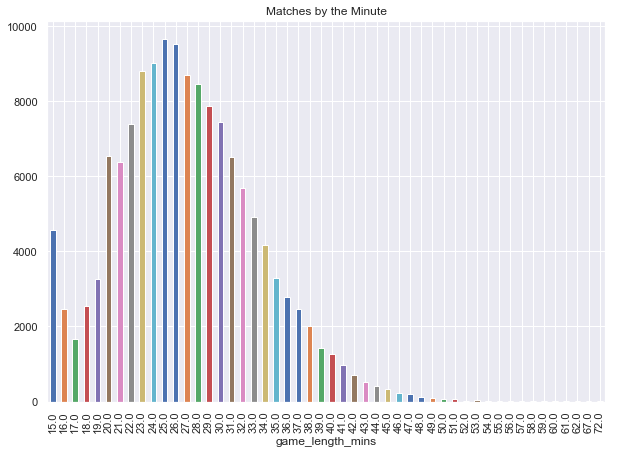

In [26]:
rg.plot(kind='bar', figsize=(10,7), title ='Matches by the Minute')


In [27]:
rc.game_length_mins.describe()

count    142773.000000
mean         27.471626
std           6.372879
min          15.016667
25%          23.100000
50%          26.950000
75%          31.400000
max          72.966667
Name: game_length_mins, dtype: float64

The average game time is around 27.47 minutes.

Taking a look at the champion picks overall

In [28]:
rc.head()

,game_length_mins,tank_count,fighter_count,assassin_count,support_count,marksman_count,mage_count
0,38.466667,2,3,2,3,3,5
1,23.400000,1,3,5,2,4,3
2,31.733333,1,4,3,3,2,5
3,35.366667,2,6,1,1,4,2
4,23.933333,0,2,4,2,5,5


In [29]:
#Role counts without game time
rc1 = rc.drop('game_length_mins', axis=1)

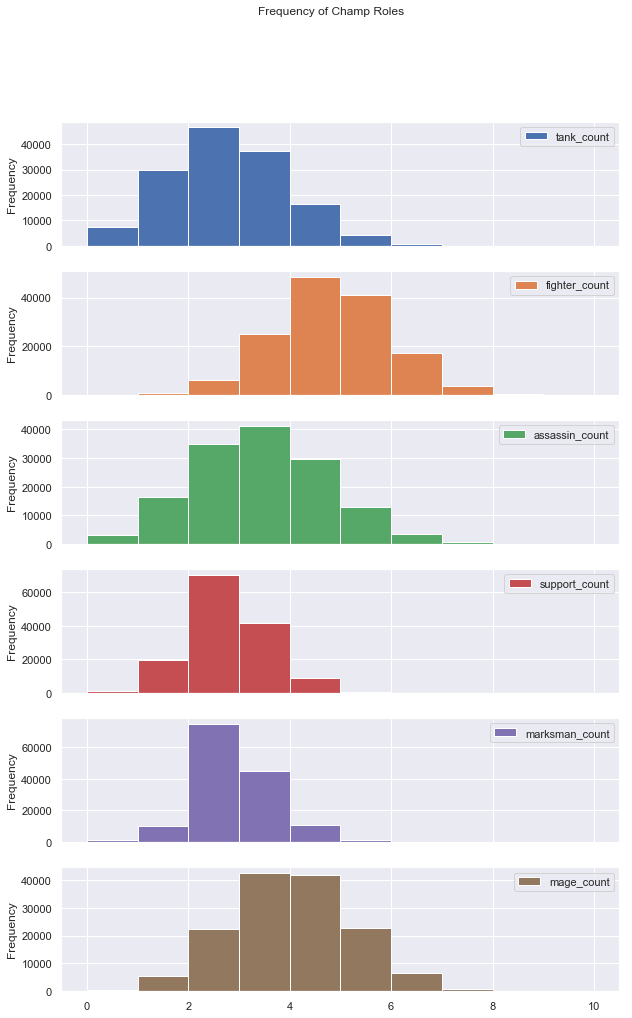

In [30]:
rc.set_index('game_length_mins').plot(kind='hist', subplots=True, figsize=(10, 16), title='Frequency of Champ Roles');

In [31]:
r1 = rc.support_count.sum()
r2 = rc.marksman_count.sum()
r3 = rc.mage_count.sum()
r4 = rc.tank_count.sum()
r5 = rc.assassin_count.sum()
r6 = rc.fighter_count.sum()
tot = r1+r2+r3+r4+r5+r6

In [32]:
print(f'supports: {r1}, {(r1/tot) * 100}%')
print(f'marksmen: {r2}, {(r2/tot) * 100}%')
print(f'mage: {r3}, {(r3/tot) * 100}%')
print(f'tank: {r4}, {(r4/tot) * 100}%')
print(f'assassin: {r5}, {(r5/tot) * 100}%')
print(f'fighter: {r6}, {(r6/tot) * 100}%')

supports: 325173, 12.81335631417554%
marksmen: 343258, 13.525990970010632%
mage: 504429, 19.876891722877524%
tank: 326048, 12.847835458430762%
assassin: 419309, 16.52276056972944%
fighter: 619549, 24.413164964776108%


You can see that the picks of marksman and support almost mirror each other, which makes sense considering that it is meta to always have a support and marksman paired together in a lane in every game.  Mage and fighters are the most popular, as they tend to have the most flexibility in item builds.

Looking at how number of tanks affect game times

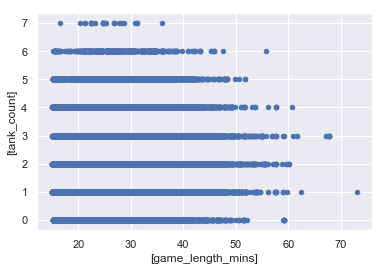

In [33]:
rc.plot(x=['game_length_mins'], y=['tank_count'], kind='scatter');

In [34]:
tank1 = rc[rc.tank_count == 1]
tank2 = rc[rc.tank_count == 2]
tank3 = rc[rc.tank_count == 3]
tank4 = rc[rc.tank_count == 4]
tank5 = rc[rc.tank_count == 5]
tank6 = rc[rc.tank_count == 6]
tank7 = rc[rc.tank_count == 7]

In [35]:
#game times with 1 tank on the team
tank1.game_length_mins.describe()

count    29891.000000
mean        27.586071
std          6.496057
min         15.016667
25%         23.100000
50%         26.983333
75%         31.566667
max         72.966667
Name: game_length_mins, dtype: float64

In [36]:
#game times with 2 tank on the team
tank2.game_length_mins.describe()

count    46605.000000
mean        27.390937
std          6.357941
min         15.016667
25%         23.033333
50%         26.900000
75%         31.300000
max         60.150000
Name: game_length_mins, dtype: float64

In [37]:
#game times with 3 tank on the team
tank3.game_length_mins.describe()

count    37280.000000
mean        27.477460
std          6.342333
min         15.016667
25%         23.150000
50%         26.950000
75%         31.383333
max         67.700000
Name: game_length_mins, dtype: float64

In [38]:
#game times with 4 tank on the team
tank4.game_length_mins.describe()

count    16565.000000
mean        27.361635
std          6.212078
min         15.016667
25%         23.066667
50%         26.866667
75%         31.183333
max         60.666667
Name: game_length_mins, dtype: float64

In [39]:
#game times with 5 tank on the team
tank5.game_length_mins.describe()

count    4232.000000
mean       27.583066
std         6.265008
min        15.183333
25%        23.200000
50%        27.016667
75%        31.604167
max        51.816667
Name: game_length_mins, dtype: float64

In [40]:
#game times with 6 tanks on the team
tank6.game_length_mins.describe()

count    583.000000
mean      27.713722
std        6.223208
min       15.250000
25%       23.600000
50%       26.916667
75%       32.483333
max       55.683333
Name: game_length_mins, dtype: float64

In [41]:
#game times with 7 tanks on the team
tank7.game_length_mins.describe()

count    27.000000
mean     25.264198
std       4.049216
min      16.500000
25%      22.450000
50%      24.633333
75%      27.283333
max      35.950000
Name: game_length_mins, dtype: float64

Having more tanks does increase overall average game time.

Games with assassins should have higher kill counts and higher chance of a champion snowballing

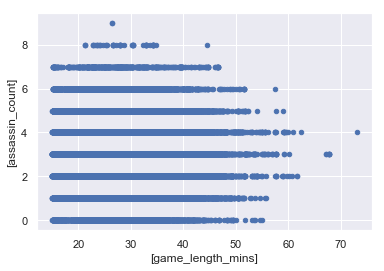

In [42]:
rc.plot(x=['game_length_mins'], y=['assassin_count'], kind='scatter');

In [43]:
a1 = rc[rc.assassin_count == 1]
a2 = rc[rc.assassin_count == 2]
a3 = rc[rc.assassin_count == 3]
a4 = rc[rc.assassin_count == 4]
a5 = rc[rc.assassin_count == 5]
a6 = rc[rc.assassin_count == 6]
a7 = rc[rc.assassin_count == 7]
a8 = rc[rc.assassin_count == 8]

In [44]:
#1 assassin on team
a1.game_length_mins.describe()

count    16578.000000
mean        27.483246
std          6.373879
min         15.016667
25%         23.050000
50%         26.950000
75%         31.516667
max         55.683333
Name: game_length_mins, dtype: float64

In [45]:
#2 assassins on team
a2.game_length_mins.describe()

count    35101.000000
mean        27.512502
std          6.370462
min         15.016667
25%         23.150000
50%         26.933333
75%         31.450000
max         61.633333
Name: game_length_mins, dtype: float64

In [46]:
#3 assassins on team
a3.game_length_mins.describe()

count    41339.000000
mean        27.490287
std          6.362795
min         15.016667
25%         23.100000
50%         26.966667
75%         31.433333
max         67.700000
Name: game_length_mins, dtype: float64

In [47]:
#4 assassins on team
a4.game_length_mins.describe()

count    29621.000000
mean        27.393545
std          6.384916
min         15.050000
25%         23.016667
50%         26.900000
75%         31.283333
max         72.966667
Name: game_length_mins, dtype: float64

In [48]:
#5 assassins on team
a5.game_length_mins.describe()

count    12843.000000
mean        27.457121
std          6.310846
min         15.033333
25%         23.200000
50%         27.050000
75%         31.250000
max         58.866667
Name: game_length_mins, dtype: float64

In [49]:
#6 assassins on team
a6.game_length_mins.describe()

count    3588.000000
mean       27.198853
std         6.319928
min        15.066667
25%        22.795833
50%        26.816667
75%        30.583333
max        57.450000
Name: game_length_mins, dtype: float64

In [50]:
#7 assassins on team
a7.game_length_mins.describe()

count    549.000000
mean      27.883151
std        7.316215
min       15.100000
25%       22.533333
50%       27.266667
75%       32.216667
max       46.600000
Name: game_length_mins, dtype: float64

In [51]:
#8 assassins on team
a8.game_length_mins.describe()

count    53.000000
mean     28.669182
std       4.798555
min      21.166667
25%      24.683333
50%      27.966667
75%      32.950000
max      44.550000
Name: game_length_mins, dtype: float64

You can see a small decrease in average game time with 4-6 assassins in a game but nothing too significant. Assassins tend to have lower health pools but high single target damage.

The highest damage roles besides the 2 marksmen(one on each team) in every game would be mages and assassins.  Lets see what the game times look like with at least 4 mages and 4 assassins in each game.

In [52]:
b1 = rc[(rc.assassin_count >= 4) & (rc.mage_count >= 4)]

In [53]:
b1.game_length_mins.describe()

count    17651.000000
mean        27.769634
std          6.642113
min         15.050000
25%         23.183333
50%         27.183333
75%         31.750000
max         72.966667
Name: game_length_mins, dtype: float64

Again nothing special.  Let's narrow down the dataframe to games above 40 mins to see what champion pool looks like

In [54]:
v = rc[rc.game_length_mins >= 40]

In [55]:
v.head()


,game_length_mins,tank_count,fighter_count,assassin_count,support_count,marksman_count,mage_count
24,42.433333,4,4,2,2,2,4
26,40.283333,3,3,2,2,3,5
28,41.950000,1,2,5,3,4,4
49,40.600000,3,4,6,2,2,2
69,40.166667,2,5,2,3,3,5


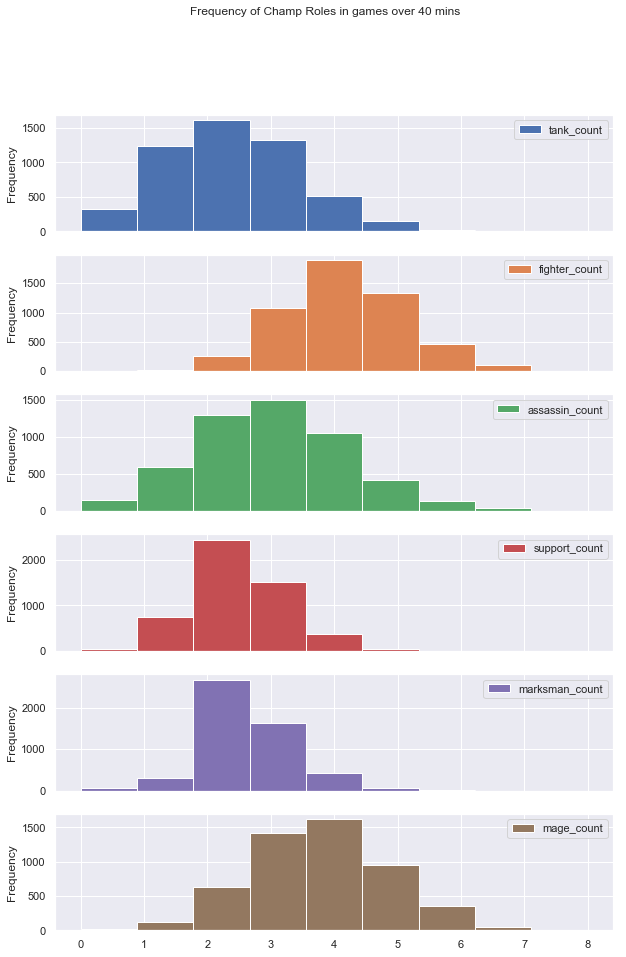

In [56]:
v.set_index('game_length_mins').plot(kind='hist', subplots=True, figsize=(10, 15),
                                     title='Frequency of Champ Roles in games over 40 mins', bins=9);

In [57]:
v1 = v.support_count.sum()
v2 = v.marksman_count.sum()
v3 = v.mage_count.sum()
v4 = v.tank_count.sum()
v5 = v.assassin_count.sum()
v6 = v.fighter_count.sum()
tot = v1+v2+v3+v4+v5+v6

In [58]:
print(f'supports: {v1}, {(v1/tot) * 100}%')
print(f'marksmen: {v2}, {(v2/tot) * 100}%')
print(f'mage: {v3}, {(v3/tot) * 100}%')
print(f'tank: {v4}, {(v4/tot) * 100}%')
print(f'assassin: {v5}, {(v5/tot) * 100}%')
print(f'fighter: {v6}, {(v6/tot) * 100}%')

supports: 11882, 12.945752481396337%
marksmen: 12582, 13.708420949413291%
mage: 19385, 21.12046893215519%
tank: 11321, 12.334528180599893%
assassin: 15025, 16.370133902792457%
fighter: 21588, 23.52069555364283%



supports: 325173, 12.81335631417554%

marksmen: 343258, 13.525990970010632%

mage: 504429, 19.876891722877524%

tank: 326048, 12.847835458430762%

assassin: 419309, 16.52276056972944%

fighter: 619549, 24.413164964776108%


What stands out the most is a mages are picked less by 1.25% and fighters are picked more by about 0.89%.  This could be due significant given the level of player skill at high rank matches.  This could also say alot about Riot's balancing team doing good a job regargless of what people think online.

Explore more questions like specific champion picks and items, look at map objectives. Figure out how to determine win rates.

In [59]:
def champ_frame(data_frame, champ_name):
    '''
    return a data frame of matches where a specific champion is played
    '''
    c1 = data_frame[data_frame.p1_champ == champ_name]
    c2 = data_frame[data_frame.p2_champ == champ_name]
    c3 = data_frame[data_frame.p3_champ == champ_name]
    c4 = data_frame[data_frame.p4_champ == champ_name]
    c5 = data_frame[data_frame.p5_champ == champ_name]
    c6 = data_frame[data_frame.p6_champ == champ_name]
    c7 = data_frame[data_frame.p7_champ == champ_name]
    c8 = data_frame[data_frame.p8_champ == champ_name]
    c9 = data_frame[data_frame.p9_champ == champ_name]
    c10 = data_frame[data_frame.p10_champ == champ_name]
    
    return pd.concat([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])

In [60]:
vaynes = champ_frame(concat, 'Vayne')

In [61]:
vaynes.head()

,blue_team_baronKills,blue_team_dragonKills,blue_team_firstBaron,blue_team_firstBlood,blue_team_firstDragon,blue_team_firstInhibitor,blue_team_firstRiftHerald,blue_team_firstTower,blue_team_inhibitorKills,blue_team_riftHeraldKills,blue_team_towerKills,blue_team_win,game_id,game_length_mins,p10_champ,p10_name,p10_spell1,p10_spell2,p10_team,p10assists,p10champLevel,p10combatPlayerScore,p10damageDealtToObjectives,p10damageDealtToTurrets,p10damageSelfMitigated,p10deaths,p10doubleKills,p10firstBloodAssist,p10firstBloodKill,p10firstInhibitorAssist,p10firstInhibitorKill,p10firstTowerAssist,p10firstTowerKill,p10goldEarned,p10goldSpent,p10inhibitorKills,p10item0,p10item1,p10item2,p10item3,p10item4,p10item5,p10item6,p10killingSprees,p10kills,p10largestCriticalStrike,p10largestKillingSpree,p10largestMultiKill,p10longestTimeSpentLiving,p10magicDamageDealt,p10magicDamageDealtToChampions,p10magicalDamageTaken,p10neutralMinionsKilled,p10neutralMinionsKilledEnemyJungle,p10neutralMinionsKilledTeamJungle,p10objectivePlayerScore,p10participantId,p10pentaKills,p10perk0,p10perk0Var1,p10perk0Var2,p10perk0Var3,p10perk1,p10perk1Var1,p10perk1Var2,p10perk1Var3,p10perk2,p10perk2Var1,p10perk2Var2,p10perk2Var3,p10perk3,p10perk3Var1,p10perk3Var2,p10perk3Var3,p10perk4,p10perk4Var1,p10perk4Var2,p10perk4Var3,p10perk5,p10perk5Var1,p10perk5Var2,p10perk5Var3,p10perkPrimaryStyle,p10perkSubStyle,p10physicalDamageDealt,p10physicalDamageDealtToChampions,p10physicalDamageTaken,p10quadraKills,p10sightWardsBoughtInGame,p10statPerk0,p10statPerk1,p10statPerk2,p10timeCCingOthers,p10totalDamageDealt,p10totalDamageDealtToChampions,p10totalDamageTaken,p10totalHeal,p10totalMinionsKilled,p10totalPlayerScore,p10totalScoreRank,p10totalTimeCrowdControlDealt,p10totalUnitsHealed,p10tripleKills,p10trueDamageDealt,p10trueDamageDealtToChampions,p10trueDamageTaken,p10turretKills,p10unrealKills,p10visionScore,p10visionWardsBoughtInGame,p10wardsKilled,p10wardsPlaced,p10win,p1_champ,p1_name,p1_spell1,p1_spell2,p1_team,p1assists,p1champLevel,p1combatPlayerScore,p1damageDealtToObjectives,p1damageDealtToTurrets,p1damageSelfMitigated,p1deaths,p1doubleKills,p1firstBloodAssist,p1firstBloodKill,p1firstInhibitorAssist,p1firstInhibitorKill,p1firstTowerAssist,p1firstTowerKill,p1goldEarned,p1goldSpent,p1inhibitorKills,p1item0,p1item1,p1item2,p1item3,p1item4,p1item5,p1item6,p1killingSprees,p1kills,p1largestCriticalStrike,p1largestKillingSpree,p1largestMultiKill,p1longestTimeSpentLiving,p1magicDamageDealt,p1magicDamageDealtToChampions,p1magicalDamageTaken,p1neutralMinionsKilled,p1neutralMinionsKilledEnemyJungle,p1neutralMinionsKilledTeamJungle,p1objectivePlayerScore,p1participantId,p1pentaKills,p1perk0,p1perk0Var1,p1perk0Var2,p1perk0Var3,p1perk1,p1perk1Var1,p1perk1Var2,p1perk1Var3,p1perk2,p1perk2Var1,p1perk2Var2,p1perk2Var3,p1perk3,p1perk3Var1,p1perk3Var2,p1perk3Var3,p1perk4,p1perk4Var1,p1perk4Var2,p1perk4Var3,p1perk5,p1perk5Var1,p1perk5Var2,p1perk5Var3,p1perkPrimaryStyle,p1perkSubStyle,p1physicalDamageDealt,p1physicalDamageDealtToChampions,p1physicalDamageTaken,p1quadraKills,p1sightWardsBoughtInGame,p1statPerk0,p1statPerk1,p1statPerk2,p1timeCCingOthers,p1totalDamageDealt,p1totalDamageDealtToChampions,p1totalDamageTaken,p1totalHeal,p1totalMinionsKilled,p1totalPlayerScore,p1totalScoreRank,p1totalTimeCrowdControlDealt,p1totalUnitsHealed,p1tripleKills,p1trueDamageDealt,p1trueDamageDealtToChampions,p1trueDamageTaken,p1turretKills,p1unrealKills,p1visionScore,p1visionWardsBoughtInGame,p1wardsKilled,p1wardsPlaced,p1win,p2_champ,p2_name,p2_spell1,p2_spell2,p2_team,p2assists,p2champLevel,p2combatPlayerScore,p2damageDealtToObjectives,p2damageDealtToTurrets,p2damageSelfMitigated,p2deaths,p2doubleKills,p2firstBloodAssist,p2firstBloodKill,p2firstInhibitorAssist,p2firstInhibitorKill,p2firstTowerAssist,p2firstTowerKill,p2goldEarned,p2goldSpent,p2inhibitorKills,p2item0,p2item1,p2item2,p2item3,p2item4,p2item5,p2item6,p2killingSprees,p2kills,p2largestCriticalStrike,p2largestKillingSpree,p2largestMultiKill,p2longestTime

In [62]:
blue_wins = vaynes[(vaynes.blue_team_win == 'Win') & ((vaynes.p1_champ == 'Vayne') | (vaynes.p2_champ == 'Vayne') | (vaynes.p3_champ == 'Vayne')
                                                      | (vaynes.p4_champ == 'Vayne') | (vaynes.p5_champ == 'Vayne'))]
red_wins = vaynes[(vaynes.red_team_win == 'Win') & ((vaynes.p6_champ == 'Vayne') | (vaynes.p7_champ == 'Vayne') | (vaynes.p8_champ == 'Vayne')
                                                      | (vaynes.p9_champ == 'Vayne') | (vaynes.p10_champ == 'Vayne'))]

wins = len(blue_wins + red_wins)
tot = len(vaynes)
winrate = wins/ tot

In [63]:
def win_rates(champs, df):
    rates = {}
    for champ in champs:
        c = champ_frame(df, champ)
        blue_wins = c[(c.blue_team_win == 'Win') & ((c.p1_champ == champ) | (c.p2_champ == champ) | (c.p3_champ == champ)
                                                      | (c.p4_champ == champ) | (c.p5_champ == champ))]
        red_wins = c[(c.red_team_win == 'Win') & ((c.p6_champ == champ) | (c.p7_champ == champ) | (c.p8_champ == champ)
                                                      | (c.p9_champ == champ) | (c.p10_champ == champ))]

        wins = len(blue_wins + red_wins)
        tot = len(c)
        win_rate = wins/ tot
        rates[champ] = win_rate
    return rates

In [64]:
wr = win_rates(champ_list, concat)

In [65]:
wr_df = pd.DataFrame.from_dict(data=list(wr.items()))

In [66]:
wr_df.columns = ['Champ', 'Win_rate']

In [67]:
wr_df.sort_values(by='Win_rate', ascending = False, inplace=True)

In [68]:
wr_df.head(25)

,Champ,Win_rate
111,Talon,0.565446
6,Annie,0.540104
88,Quinn,0.536932
8,AurelionSol,0.536824
110,Taliyah,0.532367
56,Khazix,0.531566
94,Riven,0.530126
89,Rakan,0.529187
37,Heimerdinger,0.526195
16,Cassiopeia,0.525606


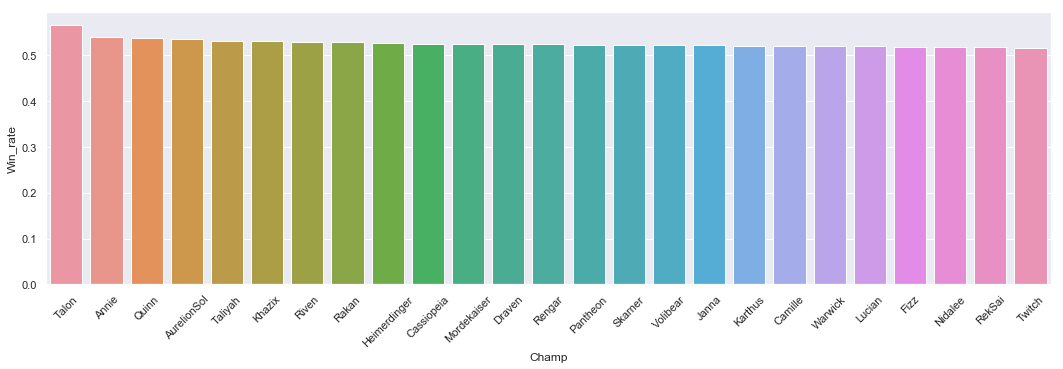

In [69]:
plt.figure(figsize=(18, 5))
plt.xticks(rotation=45)
sns.barplot(data=wr_df.head(25), x='Champ', y='Win_rate');

Top 25 champs with highest win rates above.  Below Top 25 champs with worst win rates

In [70]:
wr_df.sort_values(by='Win_rate', inplace=True)
wr_df.head(25)

,Champ,Win_rate
33,Gnar,0.439512
18,Corki,0.454800
109,TahmKench,0.459955
17,Chogath,0.465759
84,Ornn,0.466906
40,Ivern,0.467087
90,Rammus,0.469770
22,DrMundo,0.471790
9,Azir,0.472535
78,Neeko,0.472823


Explore Talon as a champion pick.  Why is his win rate so high? 

In [71]:
#Champion role
champ_type['Talon']

['Assassin', 'Fighter']

In [72]:
#play rate
champ = 'Talon'
q = champ_frame(concat, 'Talon')
qgames_played = len(q)
qplay_rate = len(q)/len(concat) * 100
total_games = len(concat)
print(f'Talon was played in {qgames_played} out of {total_games} from the data: A play rate of {qplay_rate}%')

Talon was played in 9313 out of 146704 from the data: A play rate of 6.348156832806195%


In [73]:
# take a look at games where Talon Won
#make fuctions to use any champ to find wins for a certain side or both
qn_blue_win = q[(q.blue_team_win == 'Win') & ((q.p1_champ == champ) | (q.p2_champ == champ) | (q.p3_champ == champ)
                                                      | (q.p4_champ == champ) | (q.p5_champ == champ))]
qn_red_win = q[(q.red_team_win == 'Win') & ((q.p6_champ == champ) | (q.p7_champ == champ) | (q.p8_champ == champ)
                                                      | (q.p9_champ == champ) | (q.p10_champ == champ))]
qn_both_wins = pd.concat([qn_blue_win, qn_red_win])

In [74]:
q.head()

,blue_team_baronKills,blue_team_dragonKills,blue_team_firstBaron,blue_team_firstBlood,blue_team_firstDragon,blue_team_firstInhibitor,blue_team_firstRiftHerald,blue_team_firstTower,blue_team_inhibitorKills,blue_team_riftHeraldKills,blue_team_towerKills,blue_team_win,game_id,game_length_mins,p10_champ,p10_name,p10_spell1,p10_spell2,p10_team,p10assists,p10champLevel,p10combatPlayerScore,p10damageDealtToObjectives,p10damageDealtToTurrets,p10damageSelfMitigated,p10deaths,p10doubleKills,p10firstBloodAssist,p10firstBloodKill,p10firstInhibitorAssist,p10firstInhibitorKill,p10firstTowerAssist,p10firstTowerKill,p10goldEarned,p10goldSpent,p10inhibitorKills,p10item0,p10item1,p10item2,p10item3,p10item4,p10item5,p10item6,p10killingSprees,p10kills,p10largestCriticalStrike,p10largestKillingSpree,p10largestMultiKill,p10longestTimeSpentLiving,p10magicDamageDealt,p10magicDamageDealtToChampions,p10magicalDamageTaken,p10neutralMinionsKilled,p10neutralMinionsKilledEnemyJungle,p10neutralMinionsKilledTeamJungle,p10objectivePlayerScore,p10participantId,p10pentaKills,p10perk0,p10perk0Var1,p10perk0Var2,p10perk0Var3,p10perk1,p10perk1Var1,p10perk1Var2,p10perk1Var3,p10perk2,p10perk2Var1,p10perk2Var2,p10perk2Var3,p10perk3,p10perk3Var1,p10perk3Var2,p10perk3Var3,p10perk4,p10perk4Var1,p10perk4Var2,p10perk4Var3,p10perk5,p10perk5Var1,p10perk5Var2,p10perk5Var3,p10perkPrimaryStyle,p10perkSubStyle,p10physicalDamageDealt,p10physicalDamageDealtToChampions,p10physicalDamageTaken,p10quadraKills,p10sightWardsBoughtInGame,p10statPerk0,p10statPerk1,p10statPerk2,p10timeCCingOthers,p10totalDamageDealt,p10totalDamageDealtToChampions,p10totalDamageTaken,p10totalHeal,p10totalMinionsKilled,p10totalPlayerScore,p10totalScoreRank,p10totalTimeCrowdControlDealt,p10totalUnitsHealed,p10tripleKills,p10trueDamageDealt,p10trueDamageDealtToChampions,p10trueDamageTaken,p10turretKills,p10unrealKills,p10visionScore,p10visionWardsBoughtInGame,p10wardsKilled,p10wardsPlaced,p10win,p1_champ,p1_name,p1_spell1,p1_spell2,p1_team,p1assists,p1champLevel,p1combatPlayerScore,p1damageDealtToObjectives,p1damageDealtToTurrets,p1damageSelfMitigated,p1deaths,p1doubleKills,p1firstBloodAssist,p1firstBloodKill,p1firstInhibitorAssist,p1firstInhibitorKill,p1firstTowerAssist,p1firstTowerKill,p1goldEarned,p1goldSpent,p1inhibitorKills,p1item0,p1item1,p1item2,p1item3,p1item4,p1item5,p1item6,p1killingSprees,p1kills,p1largestCriticalStrike,p1largestKillingSpree,p1largestMultiKill,p1longestTimeSpentLiving,p1magicDamageDealt,p1magicDamageDealtToChampions,p1magicalDamageTaken,p1neutralMinionsKilled,p1neutralMinionsKilledEnemyJungle,p1neutralMinionsKilledTeamJungle,p1objectivePlayerScore,p1participantId,p1pentaKills,p1perk0,p1perk0Var1,p1perk0Var2,p1perk0Var3,p1perk1,p1perk1Var1,p1perk1Var2,p1perk1Var3,p1perk2,p1perk2Var1,p1perk2Var2,p1perk2Var3,p1perk3,p1perk3Var1,p1perk3Var2,p1perk3Var3,p1perk4,p1perk4Var1,p1perk4Var2,p1perk4Var3,p1perk5,p1perk5Var1,p1perk5Var2,p1perk5Var3,p1perkPrimaryStyle,p1perkSubStyle,p1physicalDamageDealt,p1physicalDamageDealtToChampions,p1physicalDamageTaken,p1quadraKills,p1sightWardsBoughtInGame,p1statPerk0,p1statPerk1,p1statPerk2,p1timeCCingOthers,p1totalDamageDealt,p1totalDamageDealtToChampions,p1totalDamageTaken,p1totalHeal,p1totalMinionsKilled,p1totalPlayerScore,p1totalScoreRank,p1totalTimeCrowdControlDealt,p1totalUnitsHealed,p1tripleKills,p1trueDamageDealt,p1trueDamageDealtToChampions,p1trueDamageTaken,p1turretKills,p1unrealKills,p1visionScore,p1visionWardsBoughtInGame,p1wardsKilled,p1wardsPlaced,p1win,p2_champ,p2_name,p2_spell1,p2_spell2,p2_team,p2assists,p2champLevel,p2combatPlayerScore,p2damageDealtToObjectives,p2damageDealtToTurrets,p2damageSelfMitigated,p2deaths,p2doubleKills,p2firstBloodAssist,p2firstBloodKill,p2firstInhibitorAssist,p2firstInhibitorKill,p2firstTowerAssist,p2firstTowerKill,p2goldEarned,p2goldSpent,p2inhibitorKills,p2item0,p2item1,p2item2,p2item3,p2item4,p2item5,p2item6,p2killingSprees,p2kills,p2largestCriticalStrike,p2largestKillingSpree,p2largestMultiKill,p2longestTime

In [75]:
#Talon has extremely high mobility.  Let's take a look at his stats at securing map objectives
qn_map_blue = qn_blue_win[['blue_team_baronKills', 'blue_team_dragonKills', 'blue_team_firstBaron', 'blue_team_firstDragon',
                 'blue_team_firstInhibitor', 'blue_team_firstRiftHerald', 'blue_team_firstTower', 'blue_team_inhibitorKills',
                 'blue_team_riftHeraldKills', 'blue_team_towerKills']]
qn_map_red = qn_red_win[['red_team_baronKills', 'red_team_dragonKills', 'red_team_firstBaron', 'red_team_firstDragon',
                 'red_team_firstInhibitor', 'red_team_firstRiftHerald', 'red_team_firstTower', 'red_team_inhibitorKills',
                 'red_team_riftHeraldKills', 'red_team_towerKills']]

In [76]:
def build_row_stats(champ, df):
    '''
    df: should be a  ROW IN THE DATAFRAME of matches in which contains matches won
    by a specific champion regardless of team EX) qn_both_wins
    
    Build a row for dataframe containing stats for a single champion
    regardless of team
    
    Returns: dict of keys which are column labels and values which are the stats
    '''
    row = {}
    for player in range(1,11):
        if (df['p'+str(player)+'_champ'] == champ) and ((df.p1_champ == champ) |
                                                        (df.p2_champ == champ) |
                                                        (df.p3_champ == champ) |
                                                        (df.p4_champ == champ) |
                                                        (df.p5_champ == champ)):
            
            row['side'] = 'blue'
            row['baronKills'] = df.blue_team_baronKills
            row['dragonKills'] = df.blue_team_dragonKills
            row['firstBaron'] = df.blue_team_firstBaron
            row['firstBlood'] = df.blue_team_firstBlood
            row['firstDragon'] = df.blue_team_firstDragon
            row['firstInhibitor'] = df.blue_team_firstInhibitor
            row['firstRiftHerald'] = df.blue_team_firstRiftHerald
            row['firstTower'] = df.blue_team_firstTower
            row['inhibitorKills'] = df.blue_team_inhibitorKills
            row['riftHeraldKills'] = df.blue_team_riftHeraldKills
            row['towerKills'] = df.blue_team_towerKills
            row['game_id'] = df.game_id
            row['game_length'] = df.game_length_mins
            
            #problem is regex for p1 also finds p10
            player_num = str(player)
            regex = '^p'+player_num+'(?!0)'
            pattern = re.compile(regex)
            
            #Iterate through column labels to find 'player#stat' labels that match the 
            #player# that played the champ we are looking for and add those stats
            #but remove "p#" prefix before that stat name
            for name, values in df.iteritems():
                if bool(pattern.match(name)) == True:
                    prefix = len('p'+player_num)
                    col_label = name[prefix:]
                    row[col_label] = df[name]
        
        if (df['p'+str(player)+'_champ'] == champ) and ((df.p6_champ == champ) | 
                                                        (df.p7_champ == champ) | 
                                                        (df.p8_champ == champ) | 
                                                        (df.p9_champ == champ) | 
                                                        (df.p10_champ == champ)):
            
            row['side'] = 'red'
            row['baronKills'] = df.red_team_baronKills
            row['dragonKills'] = df.red_team_dragonKills
            row['firstBaron'] = df.red_team_firstBaron
            row['firstBlood'] = df.red_team_firstBlood
            row['firstDragon'] = df.red_team_firstDragon
            row['firstInhibitor'] = df.red_team_firstInhibitor
            row['firstRiftHerald'] = df.red_team_firstRiftHerald
            row['firstTower'] = df.red_team_firstTower
            row['inhibitorKills'] = df.red_team_inhibitorKills
            row['riftHeraldKills'] = df.red_team_riftHeraldKills
            row['towerKills'] = df.red_team_towerKills
            row['game_id'] = df.game_id
            row['game_length'] = df.game_length_mins
            
            player_num = str(player)
            regex = '^p'+player_num
            pattern = re.compile(regex)
            
            for name, values in df.iteritems():
                if bool(pattern.match(name)) == True:
                    prefix = len('p'+player_num)
                    col_label = name[prefix:]
                    row[col_label] = df[name]
            
    return row
                

In [77]:
#use this for wins on blue or red side do not include losses, for example use qn_both_wins
def single_champ_stat(champ, df):
    stats =[]
    for index, row in df.iterrows():
        stats.append(build_row_stats(champ, row))
    
    return pd.DataFrame(stats) 
        

In [78]:
#Games in which Talon won or lost
tal_df = single_champ_stat('Talon', q)

In [79]:
tal_df.head()

,_champ,_name,_spell1,_spell2,_team,assists,baronKills,champLevel,combatPlayerScore,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,deaths,doubleKills,dragonKills,firstBaron,firstBlood,firstBloodAssist,firstBloodKill,firstDragon,firstInhibitor,firstInhibitorAssist,firstInhibitorKill,firstRiftHerald,firstTower,firstTowerAssist,firstTowerKill,game_id,game_length,goldEarned,goldSpent,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,largestCriticalStrike,largestKillingSpree,largestMultiKill,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perk0,perk0Var1,perk0Var2,perk0Var3,perk1,perk1Var1,perk1Var2,perk1Var3,perk2,perk2Var1,perk2Var2,perk2Var3,perk3,perk3Var1,perk3Var2,perk3Var3,perk4,perk4Var1,perk4Var2,perk4Var3,perk5,perk5Var1,perk5Var2,perk5Var3,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,quadraKills,riftHeraldKills,side,sightWardsBoughtInGame,statPerk0,statPerk1,statPerk2,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,towerKills,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
0,Talon,Frostbiteismagic,SummonerFlash,SummonerIgnite,blue,5,0,16,0,4427,0,12775,10,0,2,False,True,False,False,False,False,False,False,True,True,False,False,2942776236,2200,11228,9625,0,Youmuu's Ghostblade,Corrupting Potion,Tiamat,Duskblade of Draktharr,Boots of Mobility,Serrated Dirk,Warding Totem (Trinket),0,2,604,0,1,538,404,404,13264,7,0,3,0,1,0,8112,884,0,0,8143,357,0,0,8138,10,0,0,8105,9,3,0,8233,24,30,0,8237,301,0,0,8100,8200.0,150134,13061,13370,0,1,blue,0,5008.0,5008.0,5001.0,2,162208,14892,27159,1719,204,0,0,204,1,4,0,11670,1426,523,0,0,27,0,7,11,False
1,Talon,scarra,SummonerFlash,SummonerIgnite,blue,2,2,18,0,10917,4292,14694,4,1,3,True,False,False,False,True,True,False,False,True,True,False,True,2906668290,1889,15950,13025,0,Tiamat,Youmuu's Ghostblade,Serrated Dirk,Duskblade of Draktharr,Lord Dominik's Regards,Boots of Mobility,Oracle Lens,3,9,857,3,2,806,374,374,12448,48,27,9,0,1,0,8112,1239,0,0,8139,1105,0,0,8136,11,237,0,8135,3860,5,0,8226,250,318,0,8233,23,20,0,8100,8200.0,212895,17976,11391,0,1,blue,0,NaN,NaN,NaN,5,215024,18883,24075,6634,262,0,0,453,1,11,0,1755,533,236,3,0,47,4,10,19,True
2,Talon,Rosa,SummonerFlash,SummonerIgnite,blue,4,1,17,0,16925,9178,16767,6,5,1,True,True,False,True,False,True,True,False,True,True,False,True,2897637763,1809,18749,17000,0,Ravenous Hydra,Youmuu's Ghostblade,Edge of Night,Duskblade of Draktharr,Ninja Tabi,Guardian Angel,Farsight Alteration,6,24,951,6,3,627,78,78,7212,16,0,12,0,1,0,8112,1698,0,0,8143,1361,0,0,8138,18,0,0,8105,14,5,0,8233,15,30,0,8232,2,40,0,8100,8200.0,165916,30686,15624,0,1,blue,0,NaN,NaN,NaN,3,170212,31736,24200,2644,201,0,0,257,1,8,1,4218,972,1363,6,0,28,4,5,11,True
3,Talon,shaarzard,SummonerIgnite,SummonerFlash,blue,2,0,14,0,2290,2290,14415,7,0,1,False,False,False,False,True,False,False,False,False,False,False,False,2891050936,1671,10486,9600,0,Youmuu's Ghostblade,Refillable Potion,Duskblade of Draktharr,Mercury's Treads,Hexdrinker,Caulfield's Warhammer,Warding Totem (Trinket),1,5,505,3,1,815,0,0,11082,0,0,0,0,1,0,8112,797,0,0,8143,365,0,0,8138,10,0,0,8105,11,4,0,8234,42,0,0,8275,11,0,0,8100,8200.0,117810,14618,7233,0,0,blue,0,NaN,NaN,NaN,4,124797,15538,19697,1036,196,0,0,239,1,1,0,6987,920,1382,1,0,28,2,6,10,False
4,Talon,scarra,SummonerFlash,SummonerIgnite,blue,5,1,15,0,7828,4370,8829,3,0,3,True,False,False,False,True,True,True,False,True,True,True,False,2889235589,1587,12710,11550,2,Tiamat,Youmuu's Ghostblade,NaN,Duskblade of Draktharr,Mercury's Treads,Lord Dominik's Regar

In [80]:
#Do not include remakes
tal_df = tal_df[tal_df['game_length'] > 240]

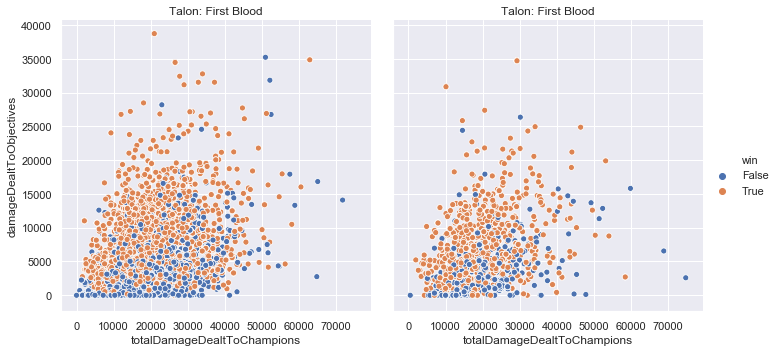

In [81]:
sns.relplot(data=tal_df, col='firstBloodKill', x='totalDamageDealtToChampions',
            y='damageDealtToObjectives', hue='win').set_titles('Talon: First Blood', 'Talon: First Blood');

*'First Blood' - player gets the first kill of the game and is awarded a gold bonus

Above visualizes whether Talon player had 'First Blood' on the left and did not get 'First Blood' on the right.

Talon is an assassin which means his play stlyle favors killing other champions 1v1.  What I wanted to see was in the games Talon players won, did they prioritize killing other players or focusing on Map Objectives to win the game.

It seems, in the few cases where a Talon player went a killing frenzy, they still still lost the game.  When focusing on taking down map objectives, there was a higher win rate.  This still makes sense overall, because League is a team based game where the final end game objective is the take down the 'Nexus' or final structure in the opponents base.

Comparing getting First Blood or not seemed relavent because Talon is a type of champion when getting a lead, can snow ball out of control and end up killing 'squishy' players in 1 or 2 seconds.

In [82]:
#Talon gets First blood 22% of the time in the games he won
len(tal_df[(tal_df.firstBloodKill == True) & (tal_df.win == True)])/len(tal_df[tal_df.win == True])

0.21933511654566298

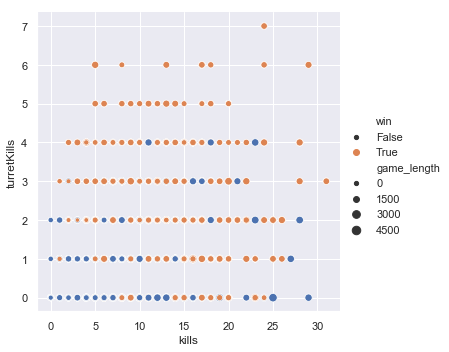

In [83]:
sns.relplot(data=tal_df, x='kills', y='turretKills',size='game_length', hue='win');

*Turrets are towers which need to be taken down to advance foward to the enemy team's base

The graph above compares number of champion kills to number of turret takedowns and whether Talon players won the game.

You see, that even with a high number of kills, as the game length drags on, Talon's win condition drops.

In [84]:
tal_win = tal_df[tal_df['win'] == True]

In [85]:
tal_win_items = tal_win[['item1', 'item2', 'item3', 'item4', 'item5', 'item6']]

In [86]:
tal_win_items.head()

,item1,item2,item3,item4,item5,item6
1,Youmuu's Ghostblade,Serrated Dirk,Duskblade of Draktharr,Lord Dominik's Regards,Boots of Mobility,Oracle Lens
2,Youmuu's Ghostblade,Edge of Night,Duskblade of Draktharr,Ninja Tabi,Guardian Angel,Farsight Alteration
4,Youmuu's Ghostblade,NaN,Duskblade of Draktharr,Mercury's Treads,Lord Dominik's Regards,Oracle Lens
5,Youmuu's Ghostblade,Tiamat,Boots of Mobility,The Black Cleaver,Duskblade of Draktharr,Warding Totem (Trinket)
8,Caulfield's Warhammer,Duskblade of Draktharr,Boots of Mobility,Lord Dominik's Regards,Serrated Dirk,Oracle Lens


In [87]:
def item_count(df):
    items = {}
    for index, row in df.iterrows():
        for item in row:
            if item not in items:
                items[item] = 1
            else:
                items[item] += 1
    return items
        

In [88]:
tal_items = item_count(tal_win_items)

In [89]:
#Because the dictionary has scalar values we need to convert to a list
tal_items_df = pd.DataFrame.from_dict(data = list(tal_items.items()))

In [90]:
tal_items_df.columns = ['Item', 'Count']

In [91]:
#Nan item is 0, which means item for that slot was empty
tal_items_df = tal_items_df.sort_values(by='Count', ascending = False).dropna()

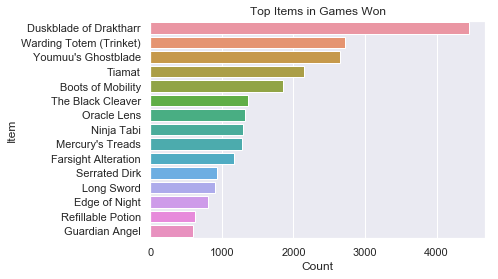

In [92]:
#Top 15 items at the end of games won, includes wards,potions, and trinkets
sns.barplot(data = tal_items_df.head(15), x='Count', y='Item').set_title('Top Items in Games Won');

There is a clear choice that Duskblade of Draktharr is a strong item on Talon

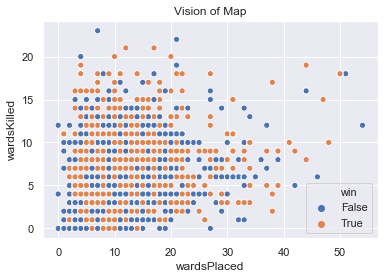

In [93]:
sns.scatterplot(data=tal_df, x='wardsPlaced', y='wardsKilled', hue='win').set_title('Vision of Map');

The above plot shows the Talon player denying vision of map to the enemy (wards killed) and how much vision he brought to his team (wards placed).  Talon has incredible movement and has the ability to jump over terrain on the map, a skill unique to him.  This gives him the advantage of warding more.  You can see that Talon players ward more than denying vision, and have higher wins as he wards more.

# Inferential Statistics EDA

Are there variables that are particularly significant in terms of explaining the answer to your project question?

Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?

What are the most appropriate tests to use to analyse these relationships?

Identify variables in the data to answer to a project question.

Identify strong correlations between pairs of independent variables or between an independent and a dependent variable. 

Practice identifying the most appropriate tests to use to analyse relationships between variables.


#### Useful Functions for inferential statistics

In [94]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1d data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [95]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates"""

    #initialize empty array of replicates 
    bs_replicates = np.empty(shape=size)
    
    #Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [96]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    #Set up array of indices to sample from
    inds = np.arange(len(x))

    #Initialize replicates
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    #generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercepr_reps

In [97]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets"""
    
    #concatenate the data sets
    data = np.concatenate((data1, data2))

    #permute the concatenated array
    permuted_data = np.random.permutation(data)

    #split the ermuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [98]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    #Initialize array of replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        #generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        #compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
        
    return perm_replicates

In [99]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    #The difference of means
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [100]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    #Set up array of indices to sample from
    inds = np.arange(len(x))

    #initialize replicates
    bs_replicates = np.empty(size)

    #Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
    
    return bs_replicates

In [101]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

### Perform tests to see if there is statistical significance between game times and certain types of champs in games.

In [102]:
rc.head()

,game_length_mins,tank_count,fighter_count,assassin_count,support_count,marksman_count,mage_count
0,38.466667,2,3,2,3,3,5
1,23.400000,1,3,5,2,4,3
2,31.733333,1,4,3,3,2,5
3,35.366667,2,6,1,1,4,2
4,23.933333,0,2,4,2,5,5


In [103]:
#observed avg game time
avg_game_time = np.mean(rc.game_length_mins)
print(avg_game_time)

27.471625587470882


In [104]:
#Array of game lengths for all games
tot_game_lengths = np.array(rc.game_length_mins)

Want to test that the there is no difference between mean game lengths regardless of champion types are picked in a game, and test this against there is a difference in game time depending on the types of champs picked.

Write code to calculate p-values for different number of champs

Below is an example at finding statistical significance between mean total game times and mean game times with games with 1 tank.  We will repeat this using games of varying champ types and counts. Below we are using 

In [105]:
#Array of game lengths for games with 1 tank in them
tank1 = rc[rc.tank_count == 1]
tank1_length = np.array(tank1.game_length_mins)
tank1_mean = np.mean(tank1_length)
print(f'The average game length for games with 1 tank: {tank1_mean}')

The average game length for games with 1 tank: 27.586070500596612


In [106]:
#diff in means between total games and games with 1 tank
diff_tank1 = diff_of_means(tank1_length, tot_game_lengths)
diff_tank1

0.1144449131255918

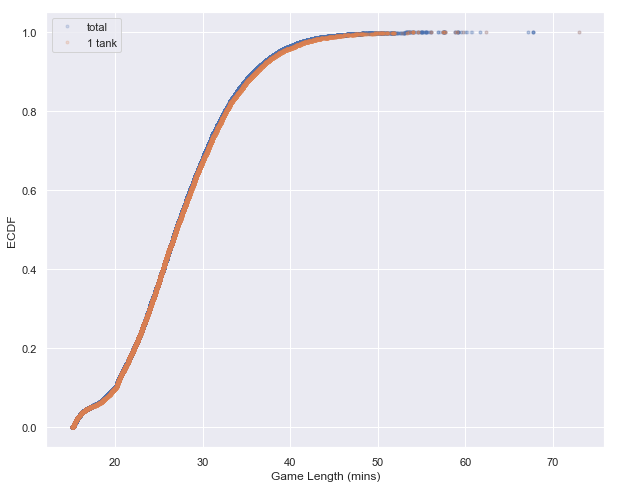

In [107]:
x_tot_games, y_tot_games = ecdf(tot_game_lengths)
x_tank1, y_tank1 = ecdf(tank1_length)

_ = plt.figure(figsize=(10, 8))
_ = plt.plot(x_tot_games, y_tot_games, marker='.', linestyle='none', alpha=0.2)
_ = plt.plot(x_tank1, y_tank1, marker='.', linestyle='none', alpha=0.2)
_ = plt.xlabel('Game Length (mins)')
_ = plt.ylabel('ECDF')
_ = plt.legend(['total', '1 tank'])
plt.show()

#### We will use bootstrapping for this specific example.

Null Hypothesis: The difference of means for game times is 0

Alternate Hypothesis:  The difference in means is greater than 0

Significance level: 0.01

In [108]:
bs_perm_reps = draw_perm_reps(tot_game_lengths, tank1_length, diff_of_means, 10000)
p = np.sum(bs_perm_reps >= diff_tank1) / len(bs_perm_reps)
p

0.0021

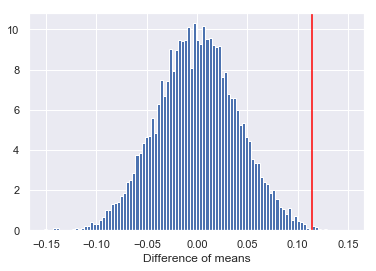

In [109]:
_ = plt.hist(bs_perm_reps, density=True, bins=int(np.sqrt(10000)))
_ = plt.axvline(x=diff_tank1, color='red')
_ = plt.xlabel('Difference of means')
plt.show()

The test above tested to see how many values were as extreme as the actual difference of means between total games and games with one tank.  The p-vale of 0.0026 is below our significance value and therefore we can reject the null hypothesis that the difference in means is the same.  Although there is statistical significance in the the difference in means, the difference in mean game times of approximately 0.1144 minutes has low practical significance.

Developers and players may not even notice the average game times varying by that much of time.

We want to test that the average game lengths for different champion types in a game can differ both in longer and shorter than average game times.  It is better that we use a two tailed test for mean game times.  This will be quicker to calculate using the frequentist approach.

#### Frequentist Approach
Null Hypothesis: The mean game times are the same between total average games and games with one tank.

Alternative Hypothesis: The mean game times are not the same.

Significance Level: 0.01

In [110]:
stats.stats.ttest_ind(tank1_length, tot_game_lengths,equal_var=False)

Ttest_indResult(statistic=2.778790004142664, pvalue=0.005458557255718668)

Again, we get similar results.  There is statisitcal significance, but there is low practical significance.  We will use the frequentist approach to test the statistical significance of mean game times for different champion roles in a game.

### Statistical and Practical Significance of Different Number of Champion Roles and its Affect on Average Game Length

Significance Level: 0.01

Null Hypothesis: The mean game lengths of total games played and having 'X' number of roles played in games are the same

Alternative Hypothesis: There is a difference between the mean game lengths of total games played and games with 'X' number of roles

To further explain,  the functions below will return lists containing the mean game lengths of games having certain number of champion roles.  For instance, the mean game times of games having 1 tank, 2 tanks, 3 tanks, 4 tanks, etc until the max number of that role.  This will be repeated for each role.  The functions will also return lists of the p-values and number of games played with that specific number of champion roles in it.  We will test the null hypothesis above for each role.

**Note that some champions have primary and secondary roles and there is no way to determine the actual playstyle a player really took on

In [111]:
rc.head()

,game_length_mins,tank_count,fighter_count,assassin_count,support_count,marksman_count,mage_count
0,38.466667,2,3,2,3,3,5
1,23.400000,1,3,5,2,4,3
2,31.733333,1,4,3,3,2,5
3,35.366667,2,6,1,1,4,2
4,23.933333,0,2,4,2,5,5


Below, these are functions which which will help automate getting p-values

In [112]:
def get_arr_roles(df, role_column):
    """
    Returns a list of arrays of game lengths for counts of specfic role.
    
    Ex) get_arr_roles(rc, 'tank_count') will return a list of arrays.
    The arrays are returned in ascending order.  Each array contains game
    lengths of games in which there are certain number of that role.
    
    """
    l = []
    min_count = min(df[role_column])
    max_count = max(df[role_column]) + 1
    
    for i in range(min_count, max_count):
        x = df[df[role_column] == i]
        arr = np.array(x['game_length_mins'])
        l.append(arr)
    
    return l
          

In [113]:
def p_val_roles(df_role_count, role_column, tot_games_arr):
    """
    Returns a list of p-values from a two tailed t-test for
    the mean game times of total games and games having a containing
    a certain number of champ types; a list mean game lengths;
    and a list that comprises of a number of games.
    
    The lists are returned in order of number of the champ type
    specified. EX) Starting at games with 0 tanks until it reaches
    games with the max number of tanks.
    
    tot_games_arr is array of mean game times for all games
    which we will test against the means game times of games having
    a certain number of each role
    """
    l_arrs = get_arr_roles(df_role_count, role_column)
    p_vals = []
    mean_length = []
    num_games = []
    
    for arr in l_arrs:
        #set equal_var to False b/c the two arrays have different sizes/variances
        p = stats.stats.ttest_ind(arr, tot_games_arr,equal_var=False)[1]
        p_vals.append(p)
        
        u = np.mean(arr)
        mean_length.append(u)
        
        games = len(arr)
        num_games.append(games)
    
    return p_vals, mean_length, num_games

In [114]:
def explain_p_values(role, p, u, n, tot):
    avg = np.mean(tot)
    for i in range(len(p)):
        print(f'{i} {role}(s): p-value: {p[i]:.4}, avg. game length: {u[i]:.6}, number of games: {n[i]}, ratio of games played:{n[i]/len(tot):.4} ')
        print(f'Diff. of avg. game length: {u[i] - avg}')

In [115]:
#mean game time
np.mean(tot_game_lengths)

27.47162558747102

#### Assassins

In [116]:
assa_p, assa_u, assa_n = p_val_roles(rc, 'assassin_count', tot_game_lengths)

In [117]:
explain_p_values('Assassin', assa_p, assa_u, assa_n, tot_game_lengths)

0 Assassin(s): p-value: 0.03197, avg. game length: 27.7271, number of games: 3099, ratio of games played:0.02171 
Diff. of avg. game length: 0.25542614964847843
1 Assassin(s): p-value: 0.8242, avg. game length: 27.4832, number of games: 16578, ratio of games played:0.1161 
Diff. of avg. game length: 0.011620280546832618
2 Assassin(s): p-value: 0.2815, avg. game length: 27.5125, number of games: 35101, ratio of games played:0.2459 
Diff. of avg. game length: 0.04087690533545185
3 Assassin(s): p-value: 0.5996, avg. game length: 27.4903, number of games: 41339, ratio of games played:0.2895 
Diff. of avg. game length: 0.01866163121674802
4 Assassin(s): p-value: 0.05537, avg. game length: 27.3935, number of games: 29621, ratio of games played:0.2075 
Diff. of avg. game length: -0.0780810301186925
5 Assassin(s): p-value: 0.8031, avg. game length: 27.4571, number of games: 12843, ratio of games played:0.08995 
Diff. of avg. game length: -0.014504977021751131
6 Assassin(s): p-value: 0.01072, a

For games with 8 and 9 assassins in them, there were very few games and the p-values from those findings can be taken out of the analysis.  Games that had 0-7 assassins played had no statistical significance on mean game lengths.

#### Tanks

In [118]:
tank_p, tank_u, tank_n = p_val_roles(rc, 'tank_count', tot_game_lengths)
explain_p_values('Tank', tank_p, tank_u, tank_n, tot_game_lengths)

0 Tank(s): p-value: 0.01717, avg. game length: 27.6549, number of games: 7590, ratio of games played:0.05316 
Diff. of avg. game length: 0.18326022719740465
1 Tank(s): p-value: 0.005459, avg. game length: 27.5861, number of games: 29891, ratio of games played:0.2094 
Diff. of avg. game length: 0.1144449131255918
2 Tank(s): p-value: 0.01743, avg. game length: 27.3909, number of games: 46605, ratio of games played:0.3264 
Diff. of avg. game length: -0.08068863506963098
3 Tank(s): p-value: 0.8744, avg. game length: 27.4775, number of games: 37280, ratio of games played:0.2611 
Diff. of avg. game length: 0.0058346235447146455
4 Tank(s): p-value: 0.03147, avg. game length: 27.3616, number of games: 16565, ratio of games played:0.116 
Diff. of avg. game length: -0.10999061413366107
5 Tank(s): p-value: 0.2544, avg. game length: 27.5831, number of games: 4232, ratio of games played:0.02964 
Diff. of avg. game length: 0.11143994498014465
6 Tank(s): p-value: 0.349, avg. game length: 27.7137, num

Ignore the results of games with 7 tanks.  There are too few games

#### Marksmen

In [119]:
mm_p, mm_u, mm_n = p_val_roles(rc, 'marksman_count', tot_game_lengths)
explain_p_values('Marksmen', mm_p, mm_u, mm_n, tot_game_lengths)

0 Marksmen(s): p-value: 0.5798, avg. game length: 27.3596, number of games: 1147, ratio of games played:0.008034 
Diff. of avg. game length: -0.11200629075494817
1 Marksmen(s): p-value: 0.0004008, avg. game length: 27.2481, number of games: 10167, ratio of games played:0.07121 
Diff. of avg. game length: -0.22356486815034415
2 Marksmen(s): p-value: 0.05867, avg. game length: 27.5261, number of games: 74584, ratio of games played:0.5224 
Diff. of avg. game length: 0.054493732132822714
3 Marksmen(s): p-value: 0.1013, avg. game length: 27.415, number of games: 44951, ratio of games played:0.3148 
Diff. of avg. game length: -0.05662592116771492
4 Marksmen(s): p-value: 0.4831, avg. game length: 27.5165, number of games: 10612, ratio of games played:0.07433 
Diff. of avg. game length: 0.04491700581959179
5 Marksmen(s): p-value: 0.08622, avg. game length: 27.7893, number of games: 1252, ratio of games played:0.008769 
Diff. of avg. game length: 0.31764491306145715
6 Marksmen(s): p-value: 0.85

Only statstical significance is is with 1 marksman.  No practical significance.  The team without a marksmen tends to be at a disadvantage, which may lead to faster wins for the team with a marksmen.

#### Supports

In [120]:
sup_p, sup_u, sup_n = p_val_roles(rc, 'support_count', tot_game_lengths)
explain_p_values('Support', sup_p, sup_u, sup_n, tot_game_lengths)

0 Support(s): p-value: 0.5678, avg. game length: 27.5793, number of games: 1223, ratio of games played:0.008566 
Diff. of avg. game length: 0.10771483226187684
1 Support(s): p-value: 6.417e-05, avg. game length: 27.6682, number of games: 19696, ratio of games played:0.138 
Diff. of avg. game length: 0.1965498457810746
2 Support(s): p-value: 0.004876, avg. game length: 27.3896, number of games: 70443, ratio of games played:0.4934 
Diff. of avg. game length: -0.0820621579369778
3 Support(s): p-value: 0.9814, avg. game length: 27.4708, number of games: 41844, ratio of games played:0.2931 
Diff. of avg. game length: -0.0008249151324939419
4 Support(s): p-value: 0.009781, avg. game length: 27.6558, number of games: 8801, ratio of games played:0.06164 
Diff. of avg. game length: 0.184155952505499
5 Support(s): p-value: 0.2792, avg. game length: 27.7417, number of games: 741, ratio of games played:0.00519 
Diff. of avg. game length: 0.2700523252595275
6 Support(s): p-value: 0.827, avg. game l

#### Mages

In [121]:
mage_p, mage_u, mage_n = p_val_roles(rc, 'mage_count', tot_game_lengths)
explain_p_values('Mage', mage_p, mage_u, mage_n, tot_game_lengths)

0 Mage(s): p-value: 0.001799, avg. game length: 26.6565, number of games: 485, ratio of games played:0.003397 
Diff. of avg. game length: -0.8151307421101954
1 Mage(s): p-value: 3.303e-29, avg. game length: 26.5394, number of games: 5418, ratio of games played:0.03795 
Diff. of avg. game length: -0.9322260550482326
2 Mage(s): p-value: 6.653e-28, avg. game length: 26.9866, number of games: 22424, ratio of games played:0.1571 
Diff. of avg. game length: -0.48507397610224956
3 Mage(s): p-value: 0.008025, avg. game length: 27.3795, number of games: 42461, ratio of games played:0.2974 
Diff. of avg. game length: -0.09216404236688547
4 Mage(s): p-value: 0.0007853, avg. game length: 27.5925, number of games: 41702, ratio of games played:0.2921 
Diff. of avg. game length: 0.12082641323238263
5 Mage(s): p-value: 7.932e-25, avg. game length: 27.9483, number of games: 22760, ratio of games played:0.1594 
Diff. of avg. game length: 0.4766923680064252
6 Mage(s): p-value: 1.13e-11, avg. game length:

These are very interesting findings, disregarding the games with 8 to 9 mages.  They all have statstical significance.  Mages have the most volatile effect on game times. But again, the practical significance of the results maybe that mages have the most diverse skills sets and diversity in play style.

#### Fighters

In [122]:
fight_p, fight_u, fight_n = p_val_roles(rc, 'fighter_count', tot_game_lengths)
explain_p_values('Fighter', fight_p, fight_u, fight_n, tot_game_lengths)

0 Fighter(s): p-value: 1.08e-05, avg. game length: 37.2043, number of games: 23, ratio of games played:0.0001611 
Diff. of avg. game length: 9.732722238615938
1 Fighter(s): p-value: 0.1472, avg. game length: 27.8178, number of games: 715, ratio of games played:0.005008 
Diff. of avg. game length: 0.34620658036114804
2 Fighter(s): p-value: 0.04622, avg. game length: 27.6428, number of games: 6188, ratio of games played:0.04334 
Diff. of avg. game length: 0.17119654138051743
3 Fighter(s): p-value: 2.216e-06, avg. game length: 27.6823, number of games: 24945, ratio of games played:0.1747 
Diff. of avg. game length: 0.21063004157955945
4 Fighter(s): p-value: 1.564e-08, avg. game length: 27.6623, number of games: 48603, ratio of games played:0.3404 
Diff. of avg. game length: 0.19070218379138382
5 Fighter(s): p-value: 0.0001034, avg. game length: 27.3347, number of games: 41151, ratio of games played:0.2882 
Diff. of avg. game length: -0.1368799757807473
6 Fighter(s): p-value: 4.008e-20, av

C:\Users\jltsa\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\jltsa\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jltsa\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jltsa\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jltsa\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Do not analyze games with 0, 8, 9, 10 fighters.

#### Analysis

Although there are results that are statistically significant, none of the results have much practical significance.  The game times barely vary more than 1 minute based on champion role composition.  This may be the result of player knowledge at the very highest level of the game.  They know what champions counter and are good against other champions.  For those unfamilar with the game, there is a draft phase before the start of matches.  Each team can banned 5 champions for a total of up to 10 champions banned.  players also pick champions in turns, allowing counter picking and formation of strategic team compositions.  These findings could also suggest that Riot Games does a very good job at balancing champion power in overall game play.  Riot Games also release constant patches to adjust power levels if certain champions are out of control. 

For futute analysis, it may be more interesting to see the same test done in lower level of play with more causual players.  At the highest level of play, you can exact more normalized results.

# DATA FOR MACHINE LEARNING

Decide what data will be used in machine learning.
<br>
What are relavant features that could predict win rates before a game starts?
<br>
Need games longer than 15 mins.
<br>
Target values are blue_team_win and red_team_win.
<br>
Features are Champ picks, summoner spells, perks, and roles.

## Extracting features and target values

In [125]:
# Converting gametime to minutes
concat.game_length_mins_mins = concat.game_length_mins / 60

In [127]:
# Only include games longer than 15 mins
concat = concat[(concat.game_length_mins > 15)]

In [137]:
pregame = concat[['p1_champ', 'p2_champ', 'p3_champ', 'p4_champ', 'p5_champ',
                 'p6_champ', 'p7_champ', 'p8_champ', 'p9_champ', 'p10_champ',
                 'game_length_mins', 'blue_team_win', 'red_team_win', 'p1_spell1',
                 'p2_spell1', 'p3_spell1', 'p4_spell1', 'p5_spell1', 'p6_spell1',
                 'p7_spell1', 'p8_spell1', 'p9_spell1', 'p10_spell1', 'p1_spell2',
                 'p2_spell2', 'p3_spell2', 'p4_spell2', 'p5_spell2', 'p6_spell2',
                 'p7_spell2', 'p8_spell2', 'p9_spell2', 'p10_spell2', 'p1perkPrimaryStyle',
                 'p2perkPrimaryStyle', 'p3perkPrimaryStyle', 'p4perkPrimaryStyle',
                 'p5perkPrimaryStyle', 'p6perkPrimaryStyle', 'p7perkPrimaryStyle',
                 'p8perkPrimaryStyle', 'p9perkPrimaryStyle', 'p10perkPrimaryStyle',
                 'p1perkSubStyle', 'p2perkSubStyle', 'p3perkSubStyle', 'p4perkSubStyle',
                 'p5perkSubStyle', 'p6perkSubStyle', 'p7perkSubStyle', 'p8perkSubStyle',
                 'p9perkSubStyle', 'p10perkSubStyle']]

In [140]:
#add roles and role counts
add_roles(pregame)
add_role_counts(pregame)

C:\Users\jltsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [141]:
pregame.head()

,p1_champ,p2_champ,p3_champ,p4_champ,p5_champ,p6_champ,p7_champ,p8_champ,p9_champ,p10_champ,game_length_mins,blue_team_win,red_team_win,p1_spell1,p2_spell1,p3_spell1,p4_spell1,p5_spell1,p6_spell1,p7_spell1,p8_spell1,p9_spell1,p10_spell1,p1_spell2,p2_spell2,p3_spell2,p4_spell2,p5_spell2,p6_spell2,p7_spell2,p8_spell2,p9_spell2,p10_spell2,p1perkPrimaryStyle,p2perkPrimaryStyle,p3perkPrimaryStyle,p4perkPrimaryStyle,p5perkPrimaryStyle,p6perkPrimaryStyle,p7perkPrimaryStyle,p8perkPrimaryStyle,p9perkPrimaryStyle,p10perkPrimaryStyle,p1perkSubStyle,p2perkSubStyle,p3perkSubStyle,p4perkSubStyle,p5perkSubStyle,p6perkSubStyle,p7perkSubStyle,p8perkSubStyle,p9perkSubStyle,p10perkSubStyle,p1_champ_prim_role,p2_champ_prim_role,p3_champ_prim_role,p4_champ_prim_role,p5_champ_prim_role,p6_champ_prim_role,p7_champ_prim_role,p8_champ_prim_role,p9_champ_prim_role,p10_champ_prim_role,p1_champ_sec_role,p2_champ_sec_role,p3_champ_sec_role,p4_champ_sec_role,p5_champ_sec_role,p6_champ_sec_role,p7_champ_sec_role,p8_champ_sec_role,p9_champ_sec_role,p10_champ_sec_role,tank_count,mage_count,marksman_count,support_count,fighter_count,assassin_count
0,Karma,Teemo,JarvanIV,Ezreal,Neeko,Ryze,Kaisa,Cassiopeia,Braum,Rengar,38.466667,Win,Fail,SummonerFlash,SummonerIgnite,SummonerFlash,SummonerFlash,SummonerFlash,SummonerTeleport,SummonerFlash,SummonerBoost,SummonerIgnite,SummonerFlash,SummonerIgnite,SummonerFlash,SummonerSmite,SummonerHeal,SummonerIgnite,SummonerFlash,SummonerHeal,SummonerFlash,SummonerFlash,SummonerSmite,8200,8200,8100,8300,8200,8200,8000,8200,8400,8100,8300,8100,8300.0,8200.0,8100.0,8100,8200.0,8100,8300,8200,Mage,Marksman,Tank,Marksman,Mage,Mage,Marksman,Mage,Support,Assassin,Support,Assassin,Fighter,Mage,Support,Fighter,None,None,Tank,Fighter,2,5,3,3,3,2
1,Teemo,Tristana,LeeSin,Bard,Leblanc,Lucian,Irelia,Blitzcrank,Orianna,Kindred,23.400000,Win,Fail,SummonerFlash,SummonerFlash,SummonerFlash,SummonerFlash,SummonerIgnite,SummonerHeal,SummonerTeleport,SummonerIgnite,SummonerBarrier,SummonerFlash,SummonerIgnite,SummonerHeal,SummonerSmite,SummonerIgnite,SummonerFlash,SummonerFlash,SummonerFlash,SummonerFlash,SummonerFlash,SummonerSmite,8200,8000,8100,8100,8100,8000,8000,8400,8200,8000,8400,8200,8300.0,8400.0,8200.0,8200,8200.0,8300,8300,8100,Marksman,Marksman,Fighter,Support,Assassin,Marksman,Fighter,Tank,Mage,Marksman,Assassin,Assassin,Assassin,Mage,Mage,None,Assassin,Fighter,Support,None,1,3,4,2,3,5
2,JarvanIV,Lux,Zyra,Jax,Kaisa,Tryndamere,Ezreal,Thresh,Xerath,Karthus,31.733333,Fail,Win,SummonerFlash,SummonerFlash,SummonerTeleport,SummonerTeleport,SummonerFlash,SummonerIgnite,SummonerHeal,SummonerIgnite,SummonerHeal,SummonerSmite,SummonerSmite,SummonerIgnite,SummonerFlash,SummonerFlash,SummonerHeal,SummonerFlash,SummonerFlash,SummonerFlash,SummonerFlash,SummonerFlash,8100,8200,8200,8000,8000,8000,8300,8400,8200,8100,8300,8000,8100.0,8300.0,8200.0,8400,8200.0,8300,8300,8000,Tank,Mage,Mage,Fighter,Marksman,Fighter,Marksman,Support,Mage,Mage,Fighter,Support,Support,Assassin,None,Assassin,Mage,Fighter,Assassin,None,1,5,2,3,4,3
3,Blitzcrank,Graves,Caitlyn,Kled,Diana,LeeSin,Lucian,Thresh,Lissandra,Urgot,35.366667,Win,Fail,SummonerIgnite,SummonerFlash,SummonerHeal,SummonerTeleport,SummonerFlash,SummonerFlash,SummonerHeal,SummonerFlash,SummonerTeleport,SummonerFlash,SummonerFlash,SummonerSmite,SummonerFlash,SummonerFlash,SummonerTeleport,SummonerSmite,SummonerFlash,SummonerIgnite,SummonerFlash,SummonerTeleport,8400,8000,8000,8000,8200,8100,8000,8400,8200,8300,8200,8200,8200.0,8400.0,8100.0,8300,8200.0,8300,8300,8400,Tank,Marksman,Marksman,Fighter,Fighter,Fighter,Marksman,Support,Mage,Fighter,Fighter,None,None,Tank,Mage,Assassin,None,Fighter,None,Marksman,2,2,4,1,6,1
4,Lux,Jhin,Gragas,Fiora,Kindred,Tristana,Fiddlesticks,Graves,Xerath,Kennen,23.933333,Fail,Win,SummonerFlash,SummonerFlash,SummonerFlash,SummonerFlash,SummonerFlash,SummonerFlash,SummonerIgnite,SummonerFlash,SummonerFlash,SummonerTeleport,SummonerIgnite,SummonerHeal,SummonerIgnite,SummonerIgnite,

In [147]:
#write to csv
#pregame.to_csv('lol_ml_data.csv', index=False)